# Basic Figures for Each Source
- included a few examples, but can run all once it looks good
- not too different from first few lines of each source notebook, but a bit simpler
- I and V band LCs
- color-mag with time stamps (another option that I've tried is also putting the interpolated I points, with time colors, onto the LC)
    - or plot V-I vs. time
- three basic periodograms with fixed bounds for each source
    - can inset periodogram searching closer to established orbital period
    - searches each OGLE epoch
- two more searches closer to established period, if there is one
    - one without detrending, one with
    - can add (or add option) to separate into years or parts with good sampling
    
- To do
    - add option to save figures (save all or particular ones)
    - make table that can be read in and out of jupyter with important values (periods, mag ranges, etc.)
    - put peaks from periodograms into dictionary automatically so that not overwritten
    - break up into functions and then call them all in basic, for better readability

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
# from lmfit.models import GaussianModel
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

In [2]:
cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

In [3]:
full[:3]

src_n,OGLE,RA_OGLE,DEC_OGLE,ra_deg,dec_deg,perr,period,Porb,_RAJ2000_1,_DEJ2000_1,__M2002_,Vmag_1,Separation_1,_RAJ2000_2,_DEJ2000_2,Vmag_2,recno,Separation
int64,str38,str11,str11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64
1,OGLE,RA,DEC,19.271511,-73.443405,0.5,0.717,3.892,19.27120833333333,-73.44333333333334,77458,13.15,0.4041071611446303,19.271369999999997,-73.44318999999999,13.152,5068334,0.7879504646408463
2,SMC732.03 \#3540,01:21:40.61,-72:57:30.9,20.41893,-72.95907,2.0,2.165,84.0,20.418999999999993,-72.95847222222221,80352,14.28,2.147142505236131,--,--,--,--,--
3,SMC720.17 \#50,00:54:33.44,-73:41:01.3,13.639167,-73.68364,0.8,2.37,18.38,13.639333333333331,-73.68369444444444,30492,14.51,0.2597014565010407,13.639544999999995,-73.68356999999999,14.729,2675272,0.4570936647419033


In [4]:
#get all source numbers
nums = cross['src_n']

In [5]:
len(nums)

58

In [176]:
def basic(index,inset=True,pbins=10,det=False,color=pink,sigmas=[100,30,20],dists=[100,100,30],medlim=True):
    '''Carry out basic anaylis of a single source
    To do: add important quantities to table; can then read and write it as needed and even set boolean to not run sources already run
    Also put peak frames into dictionary based on source number (as part of function rather than return statement)'''
    #get source number using index
    srcn = nums[index]
    #grab row for source number from full table
    row = full[full['src_n']==srcn]
    print('Source number: '+str(srcn))
    print('RA,Dec (deg): '+ str(float(row['ra_deg']))+', '+str(float(row['dec_deg'])))
    print('Established period: '+str(float(row['Porb'])))
    print('NS spin period: '+str(float(row['period'])))
    orb = float(row['Porb'])
    
    #get I and V band LCs
    ilist,vlist = o.getIV(srcn,cross,plot=True,zooms=False,figsize=(8,4),mult=(3,8),offset=10,stack=False)
    iband,vband = vstack(ilist),vstack(vlist)
    
    #color-mag
    interp = o.colormag(iband,vband,ctime=True,retint=True,figsize=(9,8)) 
    
    #get start and end dates
    stdate = iband['MJD-50000'][:1]
    endate = iband['MJD-50000'][-1:]
    trange = endate-stdate
    #three ranges for periodograms: less than 2, 2-200, 200-4000?
    #for each, save main peaks
    freq1,power1,bp1 = o.periodogram(iband,minp=0.1,maxp=2,more=True,plot=False)
    pf1 = o.findpeaks(freq1,power1,sigma=sigmas[0],distance=dists[0],pkorder=True)
    
    freq2,power2,bp2 = o.periodogram(iband,minp=2.01,maxp=200,more=True,plot=False)
    pf2 = o.findpeaks(freq2,power2,sigma=sigmas[1],distance=dists[1],pkorder=True)
    if orb>0:
        near = pf2[np.abs(orb-pf2['period'])<orb/10]
        i = 0
        #adjust distance and sigma until nearby peak identified
        while len(near)<1 and i<sigmas[1]/5:
            pf2 = o.findpeaks(freq2,power2,sigma=sigmas[1]-i*5,distance=dists[1]-i*5,pkorder=True)
            near = pf2[np.abs(orb-pf2['period'])<orb/10]
            i+=1
    freq3,power3,bp3 = o.periodogram(iband,minp=200,maxp=trange/3,more=True,plot=False)
    pf3 = o.findpeaks(freq3,power3,sigma=sigmas[2],distance=dists[2],pkorder=True)
    #plot side-by-side
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    #plot each periodogram with best period in text
    ax[0].plot(1/freq1,power1,color='black')
    ax[0].text(0.1+(2-0.1)/2,0.8*np.max(power1),f'best: {bp1:.2f}')

    ax[1].plot(1/freq2,power2,color='black')
    ax[1].text(2.01+(200-2.01)/200,0.8*np.max(power2),f'{bp2:.2f}')
    
    ax[2].plot(1/freq3,power3,color='black')
    ax[2].text(200+(trange/3-200)/2,0.8*np.max(power3),f'{bp3:.2f}')

    ax[0].set_ylabel('LS Power',fontsize=14)
    ax[0].set_xlabel('Period (days)',fontsize=14)
    #inset periodogram search closer to established period; one periodogram per OGLE epoch
    if not np.isnan(orb) and inset:
        ax[1].axvline(orb,color='darkseagreen',alpha=0.4)
        #inset search closer to orbital period for each OGLE epoch
        axins = inset_axes(ax[1], width=1.4, height=1.4,loc='upper right',borderpad=0.4)
        colors = ['navy','maroon','darkgreen']
        labels = ['OII','OIII','OIV']
        if len(ilist)==2: labels=labels[1:]
        c = 0
        low = orb-orb/10
        up = orb+orb/10
        for i in ilist:
            f,p,bp = o.periodogram(i,minp=low,maxp=up,more=True,plot=False)
            axins.plot(1/f,p,color=colors[c],label=labels[c])
            axins.set_yticks([])
#             axins.text(low+(up-low)/up,0.8*np.max(p),f'{bp:.2f}',color=colors[c])

            c+=1
        axins.axvline(orb,color='darkseagreen',alpha=0.4)
        axins.legend()
        
    #compare phase-fold of best peak near orbital period and established orbital period
    if orb>0:
        plt.rcParams['lines.linewidth'] = 2

        print('Phase-folding with established orbital period and highest peak within five days of that value...')
        orb = np.float(orb)
        np1 = float(near['period'][:1]) #highest peak
        fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
        plt.subplots_adjust(wspace=0.04)
        ax[0].errorbar(iband['MJD-50000']%orb,iband['I mag'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=4,color=color,label=f'est. pd: {orb}',zorder=1,alpha=0.4)
        ax[0].errorbar(orb+iband['MJD-50000']%orb,iband['I mag'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=4,color=color,zorder=1,alpha=0.4)
        mid,avg = o.meanphase(iband,orb,pbins=pbins,det=det,double=True)
        ax[0].plot(mid,avg,color='black',zorder=10)

        
        maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
        ax[0].set_ylim(maxi+.02,mini-.02)
        
        ax[1].errorbar(iband['MJD-50000']%np1,iband['I mag'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=3,color=color,label=f'LS peak near est.: {np1:.2f}',zorder=1,alpha=0.4)
        ax[1].errorbar(np1+iband['MJD-50000']%np1,iband['I mag'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=3,color=color,zorder=1,alpha=0.4)
        mid,avg = o.meanphase(iband,np1,pbins=pbins,det=det,double=True)

        ax[1].plot(mid,avg,color='black',zorder=10)
        
        ax[0].legend(loc='lower left')
        ax[1].legend(loc='lower left')
        ax[0].set_ylabel('I mag')
        ax[0].set_xlabel('Phase')
        
        #repeat but after detrending
        print('Repeating periodogram and phase-fold after detrending')
        window = np.arange(orb*2-int(orb/2),orb*2+11,2,dtype='int16')
        if window[0]%2 == 0: window += 1
        fig,ax = plt.subplots(1,4,figsize=(20,4))
        plt.subplots_adjust(wspace=0.25)

        bps = []
        maxpow = []
        for w in window:
            o.detrend(iband,window=w)
            freq,power,bp = o.periodogram(iband,minp=low,maxp=up,det=True,more=True,plot=False)
            ax[0].plot(1/freq,power,color='black')
            bps.append(bp)
            maxpow.append(np.max(power))
        #final detrend with low value
        finwin = int(orb*2-int(orb/2))
        if finwin%2==0: finwin+=1
        o.detrend(iband,window=finwin)
        print(f'Window shown in phase-fold: {finwin}')

        #highest-powered best period
        np1 = bps[np.argmax(maxpow)]
        ax[0].axvline(orb,color='darkseagreen',alpha=0.4,label=f'est. pd: {orb}')
        ax[0].legend()
        im = ax[3].scatter(window,bps,c=maxpow)
        fig.colorbar(im,label='Power')
        ax[3].axhline(orb,color='darkseagreen',alpha=0.4)
        
        #now phase-fold
        ax[1].errorbar(iband['MJD-50000']%orb,iband['I detrend'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=2,color=color,alpha=0.4,label=f'est. pd: {orb}',zorder=1)
        ax[1].errorbar(orb+iband['MJD-50000']%orb,iband['I detrend'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=2,color=color,alpha=0.4,zorder=1)
        mido,avgo = o.meanphase(iband,orb,pbins=pbins,det=True,double=True)
        #combine mid,avg, and the repeat
#         mido = np.concatenate([mido,orb+mido])
#         avgo = np.concatenate([avgo,avgo])
        ax[1].plot(mido,avgo,color='black',zorder=10)
#         ax[1].plot(orb+mido,avgo,color='black',zorder=10)

        
        maxi,mini = np.max(iband['I detrend']),np.min(iband['I detrend'])
        medi = np.median(iband['I detrend'])
        #cut out outliers
        if medlim:
            ax[1].set_ylim(medi+.06,medi-.06)
            ax[2].set_ylim(medi+.06,medi-.06)
        else:
            ax[1].set_ylim(maxi+.01,mini-.01)
            ax[2].set_ylim(maxi+.01,mini-.01)

        ax[2].errorbar(iband['MJD-50000']%np1,iband['I detrend'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=2,alpha=0.4,color=color,label=f'LS peak near est.: {np1:.2f}',zorder=1)
        ax[2].errorbar(np1+iband['MJD-50000']%np1,iband['I detrend'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=2,color=color,zorder=1,alpha=0.4)
        midn,avgn = o.meanphase(iband,np1,pbins=pbins,det=True,double=True)
#         midn = np.concatenate([midn,np1+midn])
#         avgn = np.concatenate([avgn,avgn])
        ax[2].plot(midn,avgn,color='black',zorder=10)
        
        ax[1].legend(loc='lower left')
        ax[2].legend(loc='lower left')
        ax[1].set_ylabel('I detrended')
        ax[1].set_xlabel('Phase')   
        ax[0].set_ylabel('LS Power')
        ax[0].set_xlabel('Period (days)')
        ax[3].set_ylabel('Peak Period')
        ax[3].set_xlabel('Detrending Window')
        
    #print useful quantites
    print('\n')
    print('max I band: ',np.max(iband['I mag']))
    print('min I band: ',np.min(iband['I mag']))
    print('I range: ',np.max(iband['I mag'])-np.min(iband['I mag']))
    print('I stdev: ',np.std(iband['I mag']))

    
    print('max V band: ',np.max(vband['V mag']))
    print('min V band: ',np.min(vband['V mag']))
    print('V range: ',np.max(vband['V mag'])-np.min(vband['V mag']))
    print('V stdev: ',np.std(vband['V mag']))

    return pf1,pf2,pf3

Source number: 2
RA,Dec (deg): 20.41893, -72.95907
Established period: 84.0
NS spin period: 2.165
I and V-I correlation: -0.9846799925699677
V and V-I correlation: -0.9546678612457401
Phase-folding with established orbital period and highest peak within five days of that value...
Repeating periodogram and phase-fold after detrending
Window shown in phase-fold: 127


max I band:  15.06
min I band:  13.983
I range:  1.077
I stdev:  0.3562511738415938
max V band:  14.753
min V band:  14.195
V range:  0.5579999999999998
V stdev:  0.1525440976517776


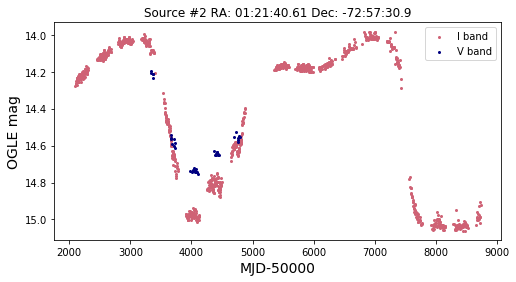

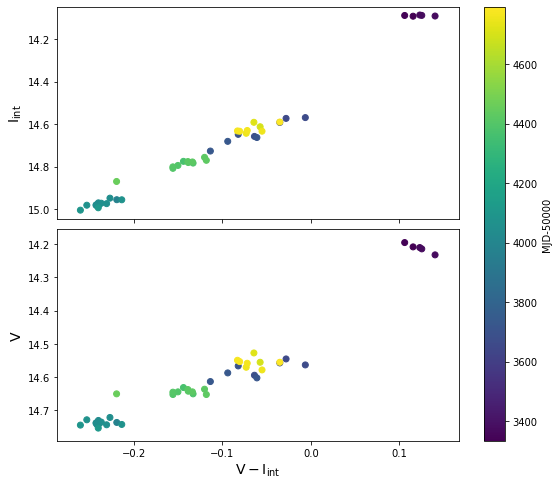

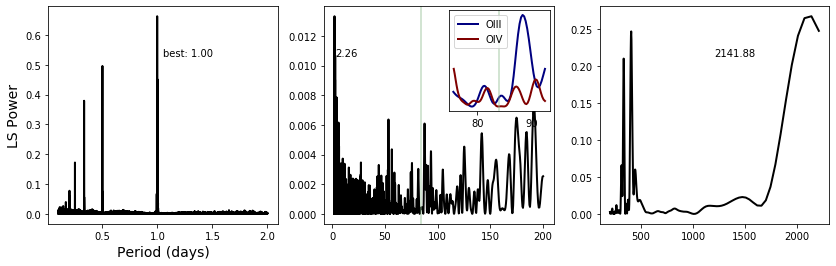

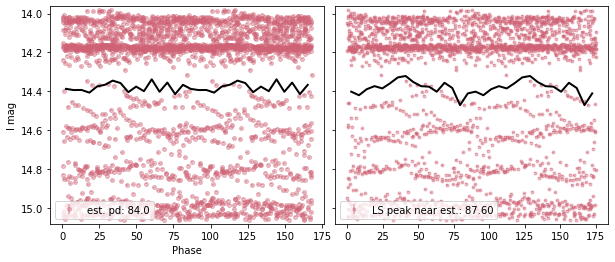

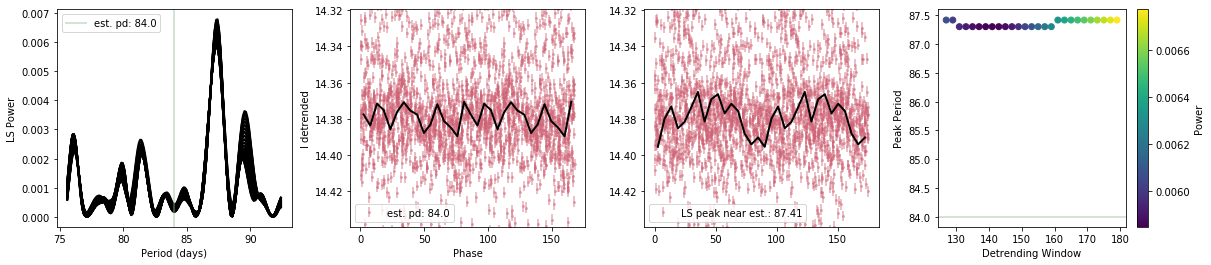

In [177]:
# reload(o)
pf1,pf2,pf3 = basic(0,pbins=16)

In [178]:
pf2[10:20] #one table for each periodogram; has peaks from periodogram; search for peaks affected by sigma and distance arguments

,period,power
33,2.574771,0.008619
47,2.248575,0.008522
7,4.333521,0.007852
16,3.385245,0.007668
34,2.537478,0.007474
48,2.230073,0.007354
53,2.152221,0.007343
30,2.656671,0.007320
0,191.354238,0.007257
20,3.138059,0.007184


Source number: 22
RA,Dec (deg): 17.785799, -73.279465
Established period: 90.5
NS spin period: 31.03
I and V-I correlation: -0.9136655015697079
V and V-I correlation: -0.42999300788629347
Phase-folding with established orbital period and highest peak within five days of that value...
Repeating periodogram and phase-fold after detrending
Window shown in phase-fold: 137


max I band:  15.429
min I band:  15.113
I range:  0.3160000000000007
I stdev:  0.05909596374360111
max V band:  15.576
min V band:  15.404
V range:  0.1720000000000006
V stdev:  0.025547074471517377


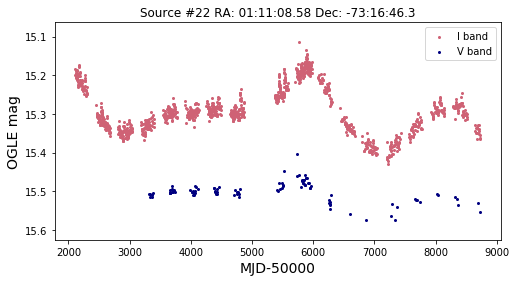

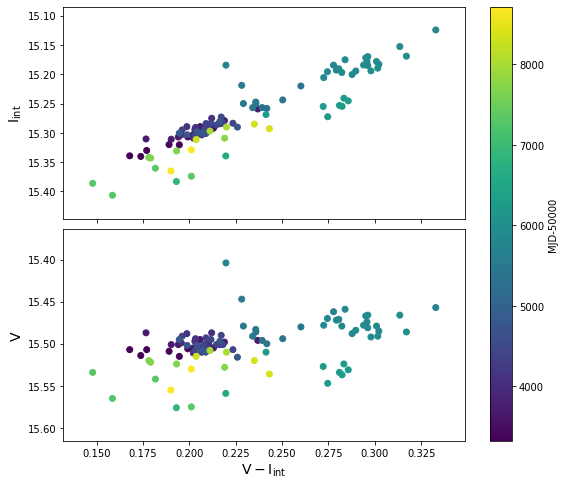

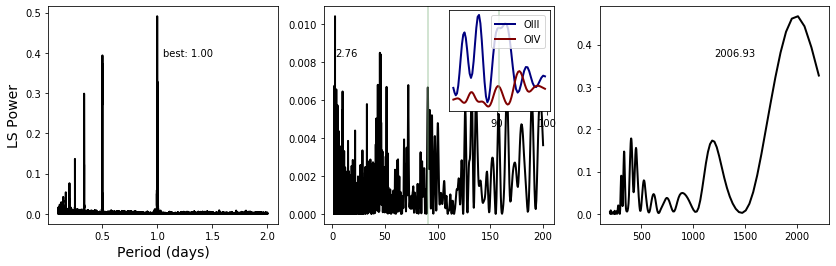

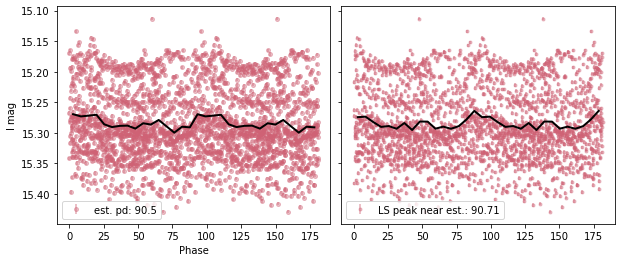

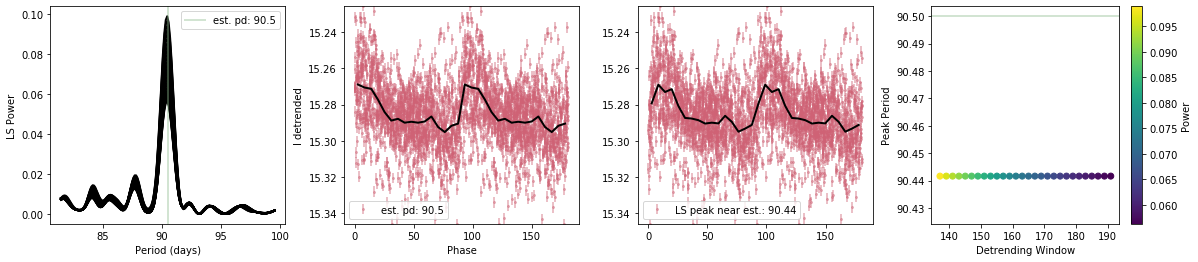

In [180]:
pf1,pf2,pf3 = basic(17,pbins=16)

Source number: 31
RA,Dec (deg): 13.35, -72.454445
Established period: 103.6
NS spin period: 138.0
I and V-I correlation: -0.9926580142506026
V and V-I correlation: -0.9549740785369608
Phase-folding with established orbital period and highest peak within five days of that value...
Repeating periodogram and phase-fold after detrending
Window shown in phase-fold: 157


max I band:  16.374
min I band:  15.71
I range:  0.6639999999999979
I stdev:  0.14025190573691002
max V band:  16.287
min V band:  16.008
V range:  0.2789999999999999
V stdev:  0.06042549284753631


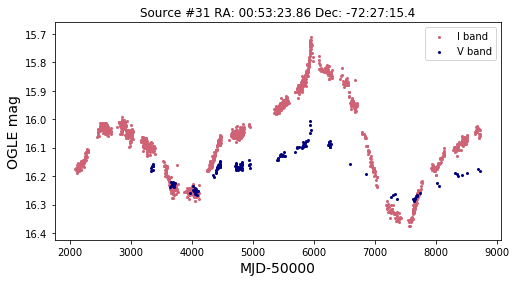

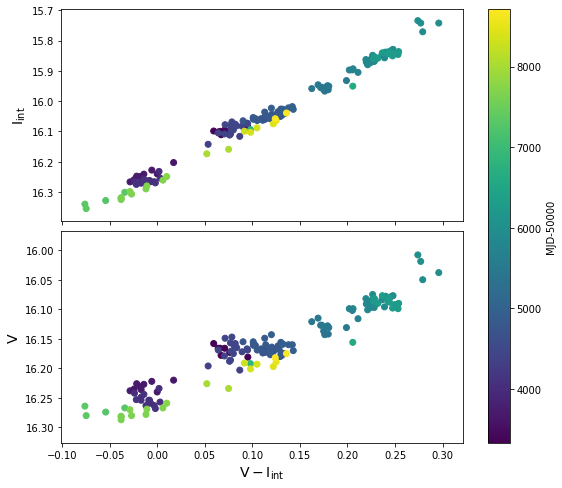

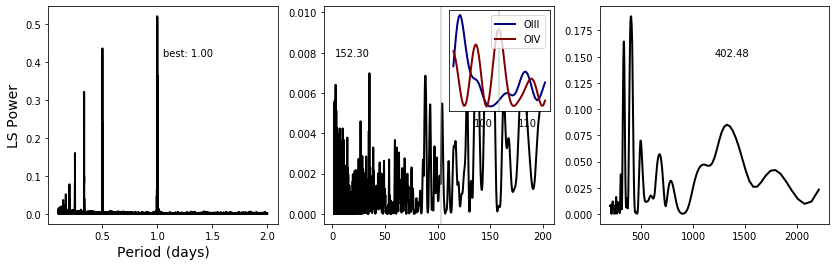

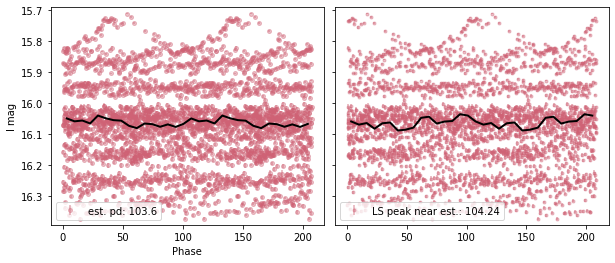

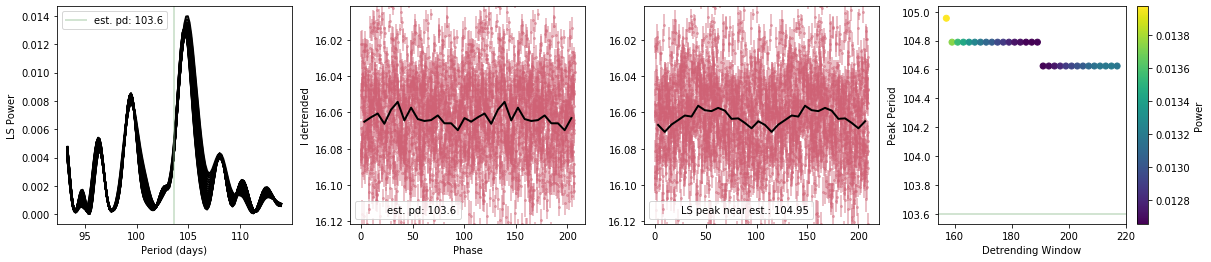

In [181]:
pf1,pf2,pf3 = basic(25,pbins=16)

In [183]:
full[57]

src_n,OGLE,RA_OGLE,DEC_OGLE,ra_deg,dec_deg,perr,period,Porb,_RAJ2000_1,_DEJ2000_1,__M2002_,Vmag_1,Separation_1,_RAJ2000_2,_DEJ2000_2,Vmag_2,recno,Separation
int64,str38,str11,str11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64
62,SMC725.23 \#10589,01:02:06.67,-71:41:16.2,15.527875,-71.68772,0.83,967.0,101.94,15.527708333333333,-71.68775000000001,52865,14.56,0.21500342107582393,15.527849999999999,-71.68780999999998,14.37,3711092,0.3207348467013553


In [184]:
cross[57]

src_n,Porb,RA_OGLE,DEC_OGLE,OII I,OII V,OIII I,OIII V,OIV I,OIV V
int64,float64,str11,str11,str38,str38,str38,str38,str49,str49
142,119.8,01:23:27.42,-73:21:22.3,--,--,smc_list/OGLE-III/I/smc121.2.50.dat,smc_list/OGLE-III/V/smc121.2.18.dat,smc_list/OGLE-IV/I/CALIBRATED/smc733.26.24.dat,smc_list/OGLE-IV/V/CALIBRATED/smc733.26.13.dat


Source number: 64
RA,Dec (deg): 15.906292, -72.0258
Established period: nan
NS spin period: 1323.0
I and V-I correlation: -0.4388904144939015
V and V-I correlation: 0.5195263979783094


max I band:  14.665
min I band:  14.479
I range:  0.18599999999999994
I stdev:  0.02984407479612393
max V band:  14.727
min V band:  14.562
V range:  0.16500000000000092
V stdev:  0.03415353164324986


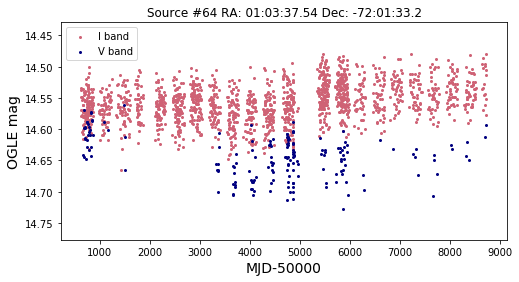

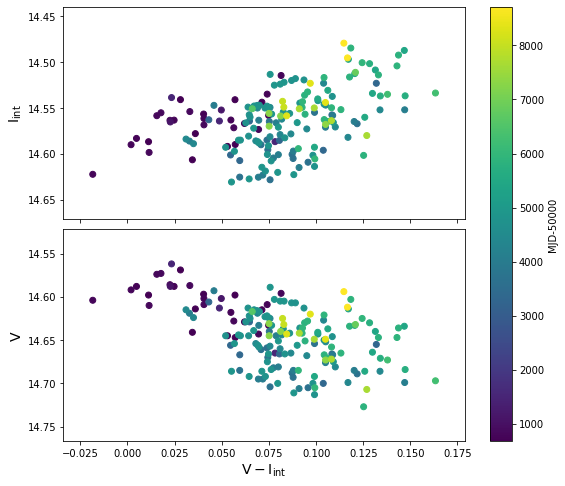

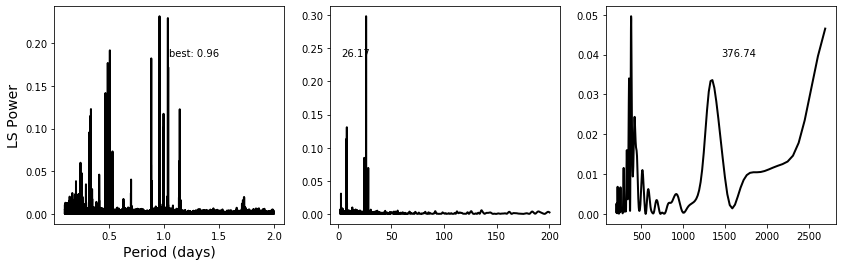

In [193]:
#example of source with no established period
pf1,pf2,pf3 = basic(54,pbins=16)